In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

In [2]:
import gc

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

test_dataset = "GUIDE_Test.csv"
chunks = []

try:
    for chunk in pd.read_csv(test_dataset, chunksize=100000, low_memory=False, encoding='utf-8'):
        try:
            chunk = optimize_memory(chunk)
            chunks.append(chunk)
        except pd.errors.ParserError:
            pass  # Skip this chunk if there's a parsing error
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("File is empty.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Concatenate all chunks if there's any valid data
if chunks:
    test_data = pd.concat(chunks, ignore_index=True)
    # Clean up memory
    del chunks
    gc.collect()
    print("Data concatenated successfully.")
else:
    print("No valid data to concatenate.")

Data concatenated successfully.


In [3]:
test_data

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147987,541165881145,262,3017,227156,2024-06-04T03:53:15.000Z,139,120,InitialAccess,T1566.002,BenignPositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4147988,438086666953,1323,31001,304819,2024-06-04T19:32:19.000Z,219,196,InitialAccess,NaN,BenignPositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Private
4147989,1297080124487,47,3653,7243,2024-06-15T00:50:22.000Z,57,29,CommandAndControl,T1046;T1071;T1210,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4147990,627065226886,70,4243,19142,2024-06-11T16:18:12.000Z,1,1,InitialAccess,T1566.002,BenignPositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Private


In [4]:
test_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

In [5]:
test_data.info

<bound method DataFrame.info of                     Id  OrgId  IncidentId  AlertId                 Timestamp  \
0        1245540519230    657       11767    87199  2024-06-04T22:56:27.000Z   
1        1400159342154      3       91158   632273  2024-06-03T12:58:26.000Z   
2        1279900255923    145       32247   131719  2024-06-08T03:20:49.000Z   
3          60129547292    222       15294   917686  2024-06-12T12:07:31.000Z   
4         515396080539    363        7615     5944  2024-06-06T17:42:05.000Z   
...                ...    ...         ...      ...                       ...   
4147987   541165881145    262        3017   227156  2024-06-04T03:53:15.000Z   
4147988   438086666953   1323       31001   304819  2024-06-04T19:32:19.000Z   
4147989  1297080124487     47        3653     7243  2024-06-15T00:50:22.000Z   
4147990   627065226886     70        4243    19142  2024-06-11T16:18:12.000Z   
4147991   326417516547    227        8384    33529  2024-06-04T18:11:09.000Z   

       

In [7]:
test_data.isna().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
ActionGrouped         4146079
ActionGranular        4146079
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4106285
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4116614
FileName                    0
FolderPath

In [9]:
test_data.dtypes

Id                       int64
OrgId                    int16
IncidentId               int32
AlertId                  int32
Timestamp               object
DetectorId               int16
AlertTitle               int32
Category                object
MitreTechniques         object
IncidentGrade         category
ActionGrouped         category
ActionGranular          object
EntityType              object
EvidenceRole          category
DeviceId                 int32
Sha256                   int32
IpAddress                int32
Url                      int32
AccountSid               int32
AccountUpn               int32
AccountObjectId          int32
AccountName              int32
DeviceName               int32
NetworkMessageId         int32
EmailClusterId         float64
RegistryKey              int16
RegistryValueName        int16
RegistryValueData        int16
ApplicationId            int16
ApplicationName          int16
OAuthApplicationId       int16
ThreatFamily            object
FileName

In [11]:
numerical_columns = test_data.select_dtypes(include=['number']).columns.tolist()
categorical_columns = test_data.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nNumerical Columns:")
print(numerical_columns)

print("\nCategorical Columns:")
print(categorical_columns)


Numerical Columns:
['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City']

Categorical Columns:
['Timestamp', 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'Usage']


In [13]:
threshold = 0.5
test_data = test_data.loc[:, test_data.isnull().mean() < threshold]
test_data

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,...,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,BenignPositive,User,...,881,289573,117668,3586,5,66,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,BenignPositive,Machine,...,881,289573,117668,3586,0,0,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,BenignPositive,Process,...,881,14,22,3586,5,66,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,FalsePositive,CloudLogonSession,...,881,289573,117668,3586,5,66,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,BenignPositive,User,...,881,289573,117668,3586,5,66,242,1445,10630,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147987,541165881145,262,3017,227156,2024-06-04T03:53:15.000Z,139,120,InitialAccess,BenignPositive,User,...,881,289573,117668,3586,5,66,242,1445,10630,Public
4147988,438086666953,1323,31001,304819,2024-06-04T19:32:19.000Z,219,196,InitialAccess,BenignPositive,User,...,881,289573,117668,3586,5,66,242,1445,10630,Private
4147989,1297080124487,47,3653,7243,2024-06-15T00:50:22.000Z,57,29,CommandAndControl,FalsePositive,Ip,...,881,289573,117668,3586,5,66,242,1445,10630,Public
4147990,627065226886,70,4243,19142,2024-06-11T16:18:12.000Z,1,1,InitialAccess,BenignPositive,Mailbox,...,881,289573,117668,3586,5,66,242,1445,10630,Private


In [14]:
Model_value=test_data["IncidentGrade"].mode()[0]
test_data["IncidentGrade"].fillna(Model_value,inplace=True)

In [15]:
test_data=test_data.drop_duplicates()

In [16]:
# Target variable distribution
print("Target variable distribution:")
test_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    1630942
TruePositive      1422856
FalsePositive      868897
Name: count, dtype: int64

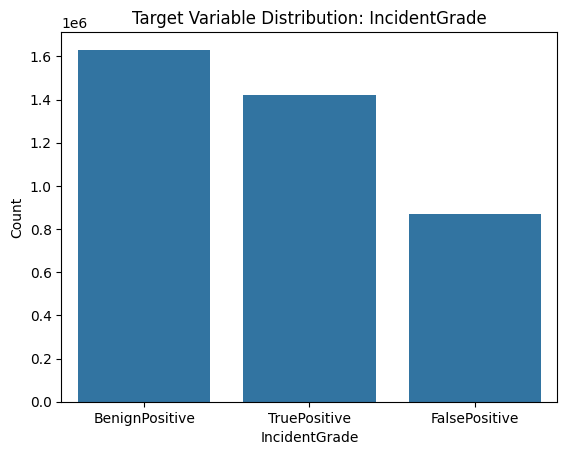

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=test_data, x='IncidentGrade', order=test_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()


In [19]:
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'])
test_data['Year'] = test_data['Timestamp'].dt.year
test_data['Month'] = test_data['Timestamp'].dt.month
test_data['Day'] = test_data['Timestamp'].dt.day
test_data['Hour'] = test_data['Timestamp'].dt.hour
test_data.drop(columns='Timestamp',inplace=True)
test_data

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,OSFamily,OSVersion,CountryCode,State,City,Usage,Year,Month,Day,Hour
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,...,5,66,242,1445,10630,Private,2024,6,4,22
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,...,0,0,242,1445,10630,Public,2024,6,3,12
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,...,5,66,242,1445,10630,Public,2024,6,8,3
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,...,5,66,242,1445,10630,Public,2024,6,12,12
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,...,5,66,242,1445,10630,Public,2024,6,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,171798692464,42,391,638112,135,7322,Malware,BenignPositive,Machine,Impacted,...,0,0,242,1445,10630,Public,2024,6,3,20
4147987,541165881145,262,3017,227156,139,120,InitialAccess,BenignPositive,User,Impacted,...,5,66,242,1445,10630,Public,2024,6,4,3
4147988,438086666953,1323,31001,304819,219,196,InitialAccess,BenignPositive,User,Impacted,...,5,66,242,1445,10630,Private,2024,6,4,19
4147989,1297080124487,47,3653,7243,57,29,CommandAndControl,FalsePositive,Ip,Related,...,5,66,242,1445,10630,Public,2024,6,15,0


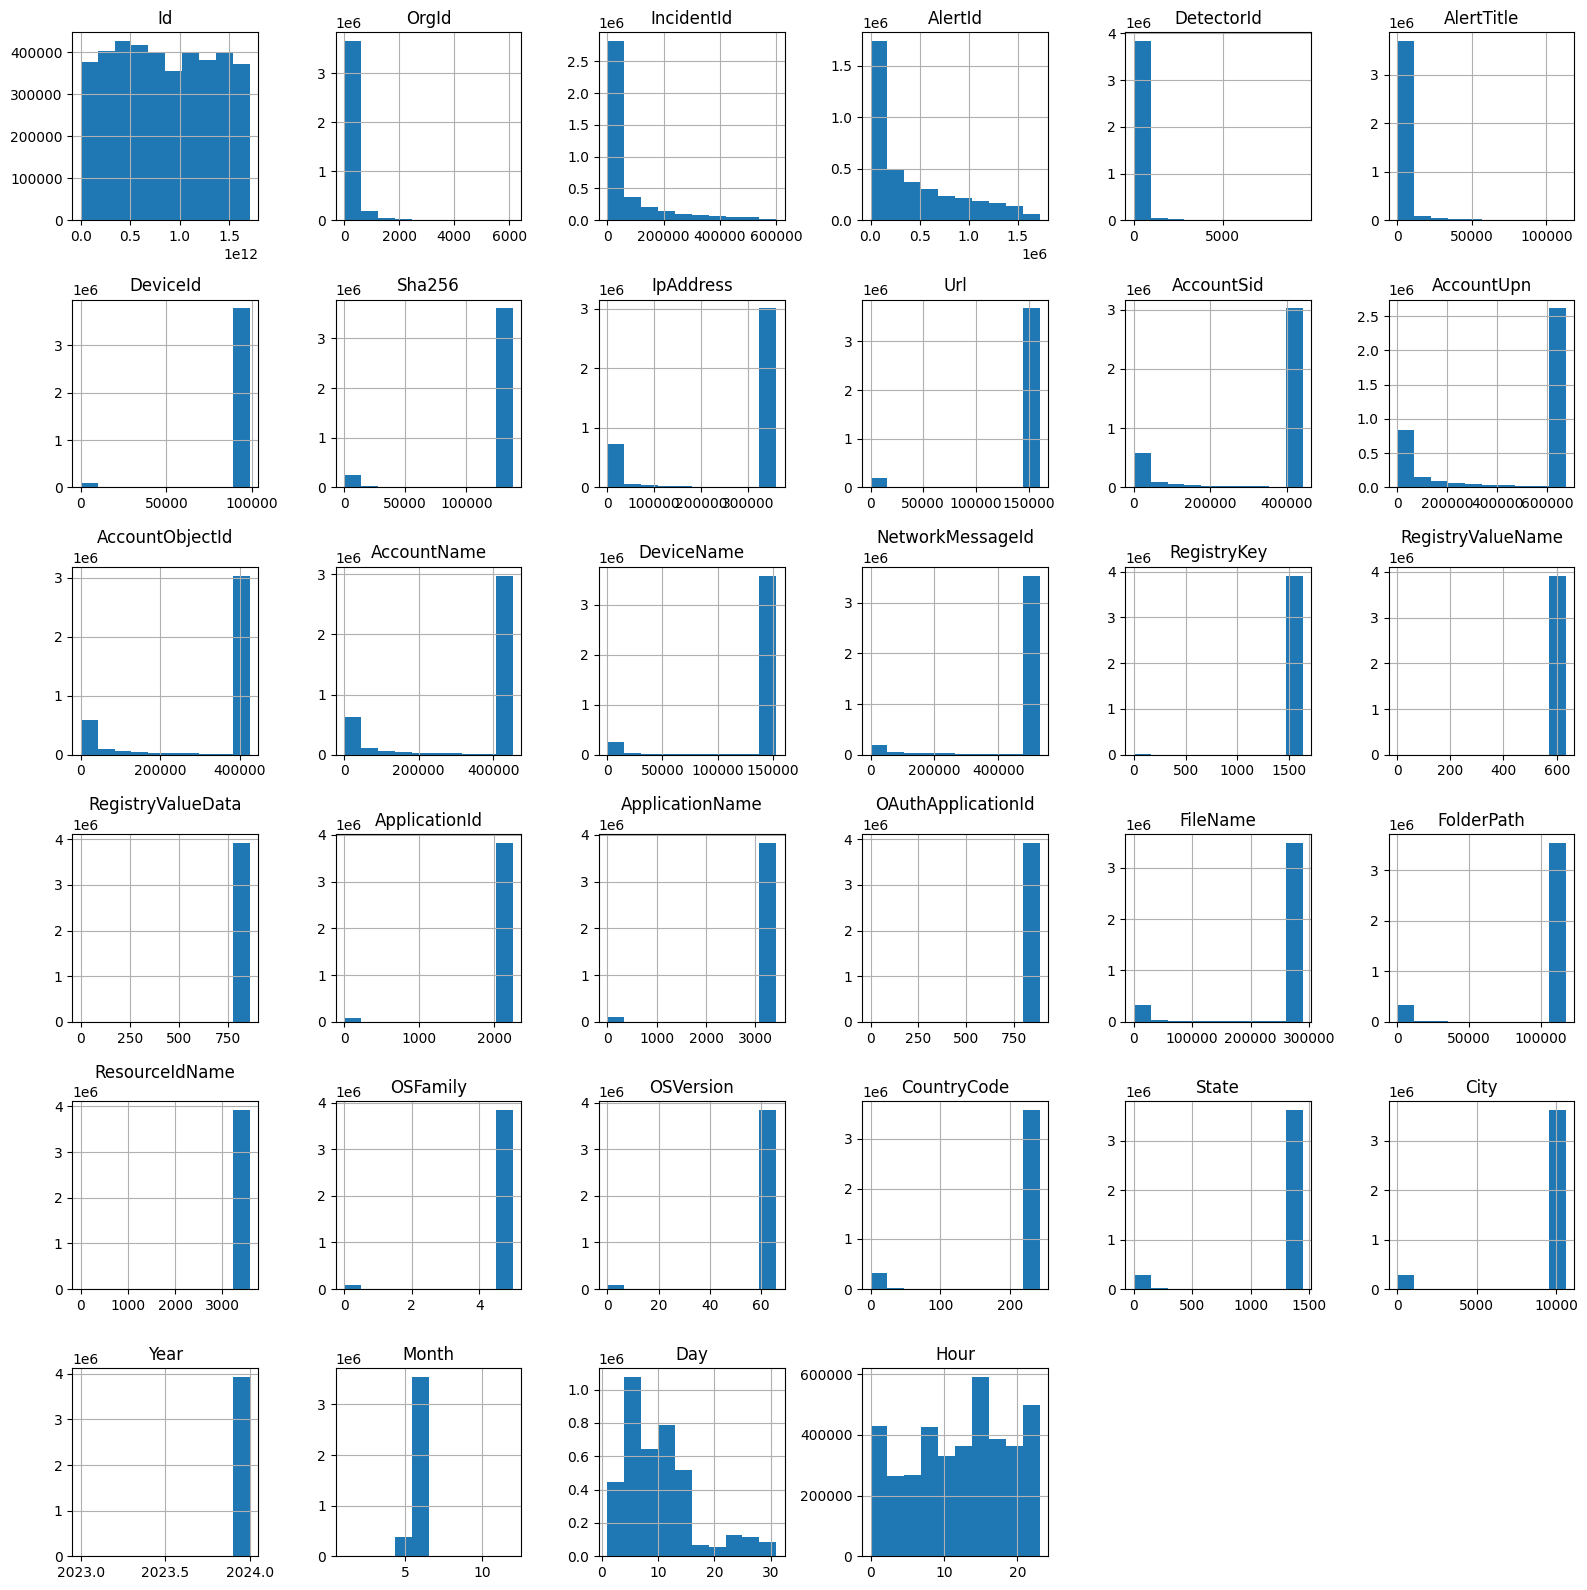

In [20]:
test_data.hist(figsize=(16,16))
plt.tight_layout()
plt.show()

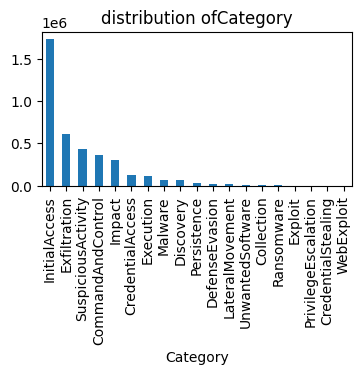

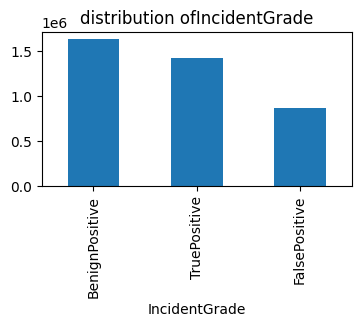

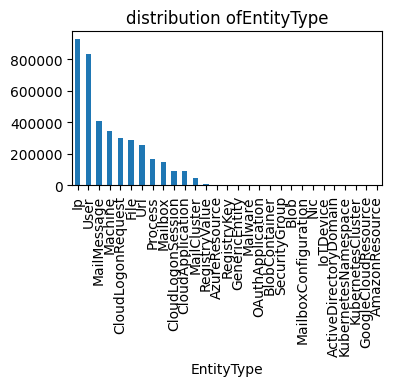

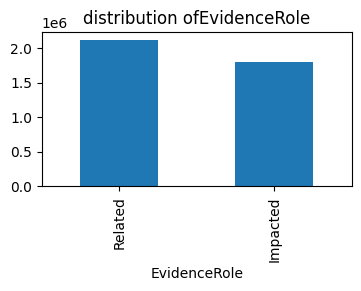

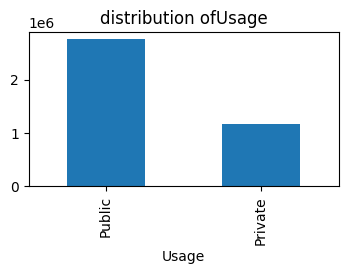

In [22]:
categorical_columns=test_data.select_dtypes(include=['object','category'])
for col in categorical_columns:
    plt.figure(figsize=(4,2))
    test_data[col].value_counts().plot(kind='bar')
    plt.title(f"distribution of{col}")
    plt.xlabel(col)
    plt.show()

In [23]:
# List of Numerical columns in DataFrame
numeric_columns = test_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
# cheking num columns
numeric_columns.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

In [24]:
import pandas as pd

# Combined list of all columns to drop from traindata analysis
columns_to_drop = [
     'AccountObjectId', 'AccountUpn', 'ApplicationName','FileName', 'FolderPath',
    'RegistryValueData', 'Url', 'EvidenceRole', 'Month', 
    'DeviceId', 'ApplicationId', 'OSFamily', 'RegistryKey', 
    'ResourceIdName', 'RegistryValueName', 'AuthApplicationId', 'Year','Usage','OAuthApplicationId',
]

# Assuming `test_data` is your test dataset DataFrame
# Drop the columns from the test dataset
test_data= test_data.drop(columns=columns_to_drop, errors='ignore')

# Display the first few rows of the modified test dataset
test_data

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,Sha256,...,AccountSid,AccountName,DeviceName,NetworkMessageId,OSVersion,CountryCode,State,City,Day,Hour
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,138268,...,2610,863,153085,529644,66,242,1445,10630,4,22
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,138268,...,441377,453297,2833,529644,0,242,1445,10630,3,12
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,4296,...,441377,453297,153085,529644,66,242,1445,10630,8,3
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,138268,...,441377,453297,153085,529644,66,242,1445,10630,12,12
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,138268,...,133549,136104,153085,529644,66,242,1445,10630,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,171798692464,42,391,638112,135,7322,Malware,BenignPositive,Machine,138268,...,441377,453297,4,529644,0,242,1445,10630,3,20
4147987,541165881145,262,3017,227156,139,120,InitialAccess,BenignPositive,User,138268,...,13354,14567,153085,529644,66,242,1445,10630,4,3
4147988,438086666953,1323,31001,304819,219,196,InitialAccess,BenignPositive,User,138268,...,95744,107151,153085,529644,66,242,1445,10630,4,19
4147989,1297080124487,47,3653,7243,57,29,CommandAndControl,FalsePositive,Ip,138268,...,441377,453297,153085,529644,66,242,1445,10630,15,0


In [25]:
test_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'Sha256', 'IpAddress',
       'AccountSid', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'OSVersion', 'CountryCode', 'State', 'City', 'Day', 'Hour'],
      dtype='object')

In [26]:
# Handling Outliers
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
            
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [27]:
df = outliers(test_data, iqr_multiplier=1.5)
df

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,Sha256,...,AccountSid,AccountName,DeviceName,NetworkMessageId,OSVersion,CountryCode,State,City,Day,Hour
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,138268,...,441377,453297,153085,529644,66,242,1445,10630,12,12
12,1391569407369,2,4993,8128,42,27,Exfiltration,BenignPositive,File,138268,...,441377,453297,153085,529644,66,242,1445,10630,7,20
27,481036339557,5,188,938345,19,15,InitialAccess,TruePositive,CloudLogonSession,138268,...,441377,453297,153085,529644,66,242,1445,10630,4,18
36,592705490728,72,153,897444,4,3,InitialAccess,TruePositive,CloudLogonRequest,138268,...,441377,453297,153085,529644,66,242,1445,10630,5,14
42,1400159341397,205,15974,148173,1,1,InitialAccess,TruePositive,MailCluster,138268,...,441377,453297,153085,529644,66,242,1445,10630,8,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147947,1082331762062,2,5823,3899,15,13,Exfiltration,BenignPositive,File,138268,...,441377,453297,153085,529644,66,242,1445,10630,4,19
4147948,1546188230107,302,61286,130823,2,2,CommandAndControl,BenignPositive,Url,138268,...,441377,453297,153085,529644,66,242,1445,10630,10,0
4147950,206158433560,2,6610,7641,15,13,Exfiltration,BenignPositive,File,138268,...,441377,453297,153085,529644,66,242,1445,10630,10,8
4147970,42949676623,3,37974,131500,2,2,CommandAndControl,BenignPositive,Url,138268,...,441377,453297,153085,529644,66,242,1445,10630,5,16


In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [29]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId','Sha256', 
              'IpAddress', 'AccountSid', 'AccountName', 
              'DeviceName', 'NetworkMessageId']

In [30]:
# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

In [31]:
# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [32]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType']

In [33]:
for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [34]:
columns_to_encode = ['State', 'City', 'OSVersion','CountryCode']
df[columns_to_encode] = df[columns_to_encode].astype(str)
df = pd.get_dummies(df, columns=columns_to_encode)

In [35]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)
df

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,Sha256,...,AccountSid,AccountName,DeviceName,NetworkMessageId,Day,Hour,State_0.0,City_0.0,OSVersion_66,CountryCode_0.0
3,60129547292,222,15294,917686,0,0.000000,6,1,2,138268,...,441377,453297,153085,529644,0.523810,0.521739,True,True,True,True
12,1391569407369,2,4993,8128,42,0.075630,4,0,3,138268,...,441377,453297,153085,529644,0.285714,0.869565,True,True,True,True
27,481036339557,5,188,938345,19,0.042017,6,2,2,138268,...,441377,453297,153085,529644,0.142857,0.782609,True,True,True,True
36,592705490728,72,153,897444,4,0.008403,6,2,1,138268,...,441377,453297,153085,529644,0.190476,0.608696,True,True,True,True
42,1400159341397,205,15974,148173,1,0.002801,6,2,6,138268,...,441377,453297,153085,529644,0.333333,1.000000,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147886,635655162565,89,28,881961,0,0.000000,6,2,2,138268,...,441377,453297,153085,529644,0.523810,0.695652,True,True,True,True
4147913,386547060185,35,210,1281042,0,0.000000,6,2,1,138268,...,441377,453297,153085,529644,0.476190,0.434783,True,True,True,True
4147936,850403527824,110,144,1023761,0,0.000000,6,2,2,138268,...,441377,453297,153085,529644,0.238095,0.304348,True,True,True,True
4147940,1322849930226,63,148,838859,0,0.000000,6,2,1,138268,...,441377,453297,153085,529644,0.619048,0.695652,True,True,True,True


In [37]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Load the saved Random Forest model
model_path = r"/Users/shashwat/Desktop/cybersec/rf_best_model.pkl"
best_rf = load(model_path)


# Separate features and target from test data
X_test = df.drop('IncidentGrade', axis=1)  
y_test = df['IncidentGrade']

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.65      0.92      0.76     81258
           1       0.75      0.86      0.80     40012
           2       1.00      0.88      0.93    339917

    accuracy                           0.88    461187
   macro avg       0.80      0.89      0.83    461187
weighted avg       0.91      0.88      0.89    461187


Macro-F1 Score: 0.83
Macro Precision: 0.80
Macro Recall: 0.89

Confusion Matrix on Test Data:
[[ 74498   6580    180]
 [  4729  34411    872]
 [ 36138   4834 298945]]
